In [2]:
import numpy as np
import jax.numpy as jnp
import jax
import scipy.linalg

import pyequion2
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [39]:
class TransportBuilder(object):
    def __init__(self, eqsys, TK, shear_velocity, kinematic_viscosity, cbulk, phases):
        self.eqsys = eqsys
        self.TK = TK
        self.shear_velocity = shear_velocity
        self.kinematic_viscosity = kinematic_viscosity
        self.cbulk = cbulk
        self.phases = phases
        
    def set_species(self, species_to_remove=[]):
        self.basedict = {k: v
                         for k, v in pyequion2.datamods.chemical_potentials.items()
                         if k in self.eqsys.solutes
                         and k not in species_to_remove}
#         self.species = list(self.basedict.keys())
        self.species = [spec for spec in eqsys.species[1:] if spec not in species_to_remove]
        self.species_ind = jnp.array([eqsys.species.index(spec) for spec in self.species])
        self.solid_ind = jnp.array([eqsys.solid_phase_names.index(phase) for phase in self.phases])
        self.reduced_formula_matrix = self.eqsys.formula_matrix[2:, self.species_ind]
        self.reduced_reaction_vector = \
            eqsys.solid_stoich_matrix[self.solid_ind, :][:, self.species_ind]
        self.closure_matrix = jnp.array(
            scipy.linalg.null_space(
                (self.reduced_formula_matrix@(self.reduced_reaction_vector.T)).T
            ).T
        )
        self.nspecies = len(self.species)
        self.logk_solid = eqsys.get_solid_log_equilibrium_constants(self.TK)[self.solid_ind]
#         self.reduced_standard_potentials = jnp.array([self.basedict[spec]['mu0'] for spec in self.species])
        self.reduced_standard_potentials = eqsys.get_standard_chemical_potentials(self.TK)[self.species_ind]
        self.reduced_standard_potentials /= (pyequion2.constants.GAS_CONSTANT*self.TK)    
        self.reduce_activity_function()
        self.reduced_diffusion_coefficients = pyequion2.equilibrium_backend.diffusion_coefficients.get_diffusion_coefficients(
                                        self.species, self.TK)
        self.reduced_diffusion_coefficients = jnp.array(self.reduced_diffusion_coefficients)/self.kinematic_viscosity
        
    def reduce_activity_function(self):
        self._actfunc = pyequion2.equilibrium_backend.ACTIVITY_MODEL_MAP[eqsys.activity_model](
                            self.species, backend="jax")
        
    def activity_model_func(self, molals, TK):
        return jnp.zeros_like(molals)
        return self._actfunc(molals, TK)[..., 1:]/pyequion2.constants.LOG10E
        
    def make_grid(self, ngrid, ymax):
        self.ngrid = ngrid
        self.npoints = ngrid + 1
        self.ymax = ymax
        self.ygrid, self.ystep = jnp.linspace(0, self.ymax, self.npoints, retstep=True)
        
    def wall_diffusion_plus(self, yplus):
        return 9.5*1e-4*yplus**3
    
    def wall_diffusion_plus_deriv(self, yplus):
        return 3*9.5*1e-4*yplus**2
    
    def bulk_boundary_condition(self, logc, mu):
        c = jnp.exp(logc)
        cbulk = self.cbulk[..., None]
        return self.reduced_formula_matrix@(c[:, -1][..., None]) - cbulk
        
    def equilibrium_wall_boundary_condition(self, logc, mu):
        c = jnp.exp(logc)
        dc = (c[:, 1] - c[:, 0])/(self.ystep)
        loga = jnp.log(c[:,0]) + self.activity_model_func(c[:,0], self.TK)
        res1 = self.reduced_reaction_vector@loga - self.logk_solid[..., None]
        res2 = self.closure_matrix@self.reduced_formula_matrix@dc[..., None]
        res = jnp.vstack([res1, res2])
        return res
    
    def modelled_wall_boundary_condition(self, logc, mu):
        c = jnp.exp(logc)
        dc = (c[:, 1] - c[:, 0])/(self.ystep)
        loga = jnp.log(c[:,0]) + self.activity_model_func(c[:,0], self.TK)
        logsatur = self.reduced_reaction_vector@loga - self.logk_solid[..., None]
        fsatur = jnp.clip(jnp.exp(logsatur)-1, 0.0, jnp.inf)*1e-3
        res = self.reduced_formula_matrix@dc[..., None] \
              - self.reduced_formula_matrix@(self.reduced_reaction_vector.T)@fsatur
        return res

    def transport_residual(self, logc, mu):
        #logc : (nsolutes, ngrid)
        #mu : (nsolutes, ngrid)
        c = jnp.exp(logc)
        ymiddle = self.ygrid[1:-1]
        cm = c[:, 1:-1]
        d1c = (c[:, 2:] - c[:, :-2])/(2*self.ystep) #(nsolutes, ngrid-2)
        d1mu = (mu[:, 2:] - mu[:, :-2])/(2*self.ystep) #(nsolutes, ngrid-2)
        d2c = (c[:, 2:] - 2*c[:, 1:-1] + c[:, :-2])/(self.ystep**2) #(nsolutes, ngrid-2
        d2mu = (mu[:, 2:] - 2*mu[:, 1:-1] + mu[:, :-2])/(self.ystep**2) #(nsolutes, ngrid-2)        
        molecular_diffusions = self.reduced_diffusion_coefficients[..., None] #(nsolutes, 1)
        turbulent_diffusions = self.wall_diffusion_plus(ymiddle)
        turbulent_diffusions_deriv = self.wall_diffusion_plus_deriv(ymiddle)
        term1 = molecular_diffusions*(d1c*d1mu + cm*d2mu)
        term2 = turbulent_diffusions*d2c + turbulent_diffusions_deriv*d1c
        term = term1 + term2
        res = self.reduced_formula_matrix@term
        return res
                
    def potential_residual(self, logc, mu):
        logg = self.activity_model_func(jnp.exp(logc).T, self.TK).T
        mu0 = self.reduced_standard_potentials[..., None]
        return mu - (mu0 + logg + logc)
    
    def full_residual(self, logcmu):
        n = logcmu.shape[0]
        logc = logcmu[:n//2, :]
        mu = logcmu[n//2:, :]
        res1a = self.modelled_wall_boundary_condition(logc, mu)
        res1b = self.transport_residual(logc, mu)
        res1c = self.bulk_boundary_condition(logc, mu)
        res1 = jnp.hstack([res1a, res1b, res1c])
        res3 = self.potential_residual(logc, mu)
        res = jnp.vstack([res1, res3])
        return res
    
    def bulk_residual(self, logcmu):
        n = logcmu.shape[0]
        logc = logcmu[:n//2, :]
        mu = logcmu[n//2:, :]
        res1 = self.bulk_boundary_condition(logc, mu)
        print(res1)
        res3 = self.potential_residual(logc, mu)
        print(res3)
        res = jnp.vstack([res1, res3])
        return res

    def gibbs_free_energy(self, logcmu):
        n = logcmu.shape[0]
        logc = logcmu[:n//2, :]
        mu = logcmu[n//2:, :]
        c = jnp.exp(logc)
        return jnp.mean(jnp.sum(c*mu, axis=0))    
    
    def flattened_equality_constraint(self, x):
        cmu = x.reshape(2*self.nspecies, self.npoints)
        return self.full_residual(cmu).flatten()
    
    def flattened_minimization_objective(self, x):
        cmu = x.reshape(2*self.nspecies, self.npoints)
        return self.gibbs_free_energy(cmu).flatten()[0]
        
    def wall_length(self):
        return self.kinematic_viscosity/self.shear_velocity
    
    def wall_time(self):
        return self.kinematic_viscosity/(self.shear_velocity**2)
    
    def get_log_equilibrium_constants(self, TK):
        return self.eqsys.get_log_equilibrium_constants(TK)


In [40]:
eqsys = pyequion2.EquilibriumBackend(["Na", "Cl", "Ca", "C"], from_elements=True, backend="jax", logbase="e")

In [53]:
eqsys.species

['H2O',
 'CO2',
 'CO3--',
 'Ca++',
 'CaCO3',
 'CaHCO3+',
 'CaOH+',
 'Cl-',
 'H+',
 'HCO3-',
 'Na+',
 'Na2CO3',
 'NaCO3-',
 'NaHCO3',
 'NaOH',
 'OH-']

In [56]:
builder = TransportBuilder(eqsys, 298.15, 0.1, 1e-6, jnp.array([1e-1, 1e-1, 1e-1, 1e-1, 0.0]), ["Calcite"])
builder.set_species(['CaCO3', 'CaHCO3+', 'CCaOH+', 'Na2CO3', 'NaCO3-', 'NaHCO3', 'NaOH', 'CaOH+'])
builder.make_grid(60, 5)
builder.species

['CO2', 'CO3--', 'Ca++', 'Cl-', 'H+', 'HCO3-', 'Na+', 'OH-']

In [57]:
logc = np.ones([builder.nspecies, builder.npoints])*0.0 - 3.0
mu = builder.reduced_standard_potentials[..., None] + logc
logcmu = jnp.vstack([logc, mu])

In [58]:
constraints = {'type':'eq',
               'fun':jax.jit(builder.flattened_equality_constraint),
               'jac':jax.jit(jax.jacfwd(builder.flattened_equality_constraint))}
equality_constraint = scipy.optimize.NonlinearConstraint(
    jax.jit(builder.flattened_equality_constraint),
    lb=0.0,
    ub=0.0,
    jac = jax.jit(jax.jacfwd(builder.flattened_equality_constraint)))


In [60]:
sol = scipy.optimize.minimize(jax.jit(builder.flattened_minimization_objective),
                              logcmu.flatten(),
                              jac = jax.jit(jax.grad(builder.flattened_minimization_objective)),
                              constraints=constraints,
                              method='trust-constr')

In [61]:
sol.success

True

In [62]:
logcmu = sol.x.reshape(builder.nspecies*2, builder.npoints)
logc, mu = logcmu[:builder.nspecies, :], logcmu[builder.nspecies:, :]
c = np.exp(logc)

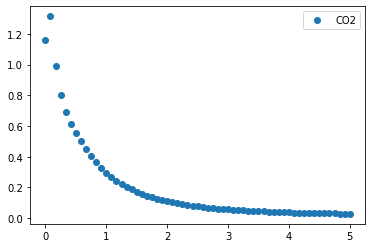

In [75]:
i = 0
plt.plot(builder.ygrid, c[i, :], 'o', label=builder.species[i])
plt.legend()